In [1]:
#Khai báo thư viện
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
from pycocotools.coco import COCO
# Bây giờ, chúng ta sẽ xác định các phép biến đổi của mình
from albumentations.pytorch import ToTensorV2

In [4]:
#Chúng tôi sử dụng albumentations làm thư viện tăng cường dữ liệu của mình do khả năng xử lý các hộp giới hạn ở nhiều định dạng
#định nghĩa hàm
def get_transforms(train=False):
 # Nếu train=False, chúng ta chỉ định nghĩa một phép biến đổi duy nhất:
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # kích thước đầu vào của chúng tôi có thể là 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # kích thước đầu ra của chúng tôi có thể là 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform


In [5]:
#định nghĩa class kế thừa từ dataset
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
     # 3 tham số biến đổi được yêu cầu cho bộ dữ liệu.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # chú thích được lưu trữ ở đây
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # định dạng chú thích bắt buộc cho albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # chuyển từ xywh sang xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {}# đây là mục tiêu đã được chuyển đổi của chúng tôi
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])# chúng tôi có một khu vực khác
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ #hình ảnh tỉ lệ
    def __len__(self):
        return len(self.ids)


In [6]:
dataset_path = "/content/drive/MyDrive/tgmtlt"

In [7]:
#load classes
#chúng ta sử dụng COCO API để tải và xem thông tin về các lớp (classes) trong tập dữ liệu.
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=3.09s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [8]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [9]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


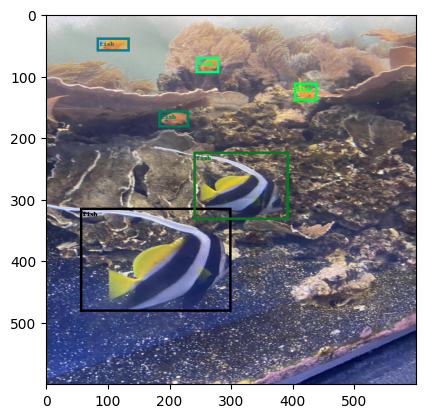

In [10]:
# xem 1 mẫu dữ liệu đã được train trước đó
sample = train_dataset[3]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [11]:
len(train_dataset)

447

In [12]:
#  tải mô hình faster RCnn mobile netv3 mô hình nhỏ gọn giúp tiến trình xử lý nhanh hơn.
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 146MB/s]


In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))
    #định nghĩa hàm được sử dụng trong quá trình tạo batch từ các mẫu trong tập dữ liệu

In [14]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
#sử dụng lớp DataLoader từ thư viện torch.utils.data để tạo ra một vòng lặp huấn luyện (training loop) cho tập dữ liệu huấn luyện train_dataset.

In [15]:
#sử dụng train_loader (đã được khởi tạo từ DataLoader) để lấy một batch dữ liệu từ tập dữ liệu huấn luyện.
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) #đảm bảo cho nó chạy không lỗi

In [16]:
device = torch.device("cuda")

In [17]:
model = model.to(device)

In [18]:
# Bây giờ và trình tối ưu hóa
#tạo một trình tối ưu hóa (optimizer) cho mô hình.
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [19]:
import sys

In [20]:
#định nghĩa một hàm train_one_epoch để huấn luyện mô hình
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):# Lặp qua từng batch dữ liệu trong loader. Mỗi batch chứa các hình ảnh (images) và các nhãn tương ứng (targets).
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()


    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [21]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()
#chúng ta huấn luyện mô hình trong nhiều epoch bằng cách chạy vòng lặp từ 0 đến num_epochs - 1.
# huấn luyện mô hình trong một số epoch nhất định bằng cách chạy vòng lặp từ 0 đến num_epochs - 1 và cập nhật các tham số của mô hình sau mỗi epoch.

100%|██████████| 112/112 [00:42<00:00,  2.61it/s]


Epoch 0, lr: 0.010000, loss: 1.013394, loss_classifier: 0.480553, loss_box: 0.399066, loss_rpn_box: 0.033152, loss_object: 0.100624


100%|██████████| 112/112 [00:22<00:00,  5.09it/s]


Epoch 1, lr: 0.010000, loss: 0.804141, loss_classifier: 0.375492, loss_box: 0.339016, loss_rpn_box: 0.028646, loss_object: 0.060987


100%|██████████| 112/112 [00:20<00:00,  5.41it/s]


Epoch 2, lr: 0.010000, loss: 0.732501, loss_classifier: 0.323613, loss_box: 0.334602, loss_rpn_box: 0.027201, loss_object: 0.047086


100%|██████████| 112/112 [00:20<00:00,  5.35it/s]


Epoch 3, lr: 0.010000, loss: 0.694599, loss_classifier: 0.280313, loss_box: 0.347471, loss_rpn_box: 0.025385, loss_object: 0.041429


100%|██████████| 112/112 [00:19<00:00,  5.61it/s]


Epoch 4, lr: 0.010000, loss: 0.678714, loss_classifier: 0.271644, loss_box: 0.348164, loss_rpn_box: 0.024323, loss_object: 0.034583


100%|██████████| 112/112 [00:19<00:00,  5.60it/s]


Epoch 5, lr: 0.010000, loss: 0.654566, loss_classifier: 0.248925, loss_box: 0.349313, loss_rpn_box: 0.023082, loss_object: 0.033245


100%|██████████| 112/112 [00:20<00:00,  5.53it/s]


Epoch 6, lr: 0.010000, loss: 0.644475, loss_classifier: 0.240859, loss_box: 0.348626, loss_rpn_box: 0.022956, loss_object: 0.032034


100%|██████████| 112/112 [00:19<00:00,  5.69it/s]


Epoch 7, lr: 0.010000, loss: 0.632441, loss_classifier: 0.234944, loss_box: 0.345777, loss_rpn_box: 0.022169, loss_object: 0.029551


100%|██████████| 112/112 [00:21<00:00,  5.33it/s]


Epoch 8, lr: 0.010000, loss: 0.624872, loss_classifier: 0.233866, loss_box: 0.339788, loss_rpn_box: 0.021494, loss_object: 0.029724


100%|██████████| 112/112 [00:20<00:00,  5.46it/s]

Epoch 9, lr: 0.010000, loss: 0.625276, loss_classifier: 0.229566, loss_box: 0.349795, loss_rpn_box: 0.020714, loss_object: 0.025201


In [22]:
# we will watch first epoich to ensure no errrors
# trong khi nó đang huấn luyện, hãy viết mã để xem dự đoán của mô hình. hãy thử lại lần nữa
model.eval()
torch.cuda.empty_cache()

In [23]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))
#tạo một đối tượng test_dataset từ lớp AquariumDetection. Đối tượng này được sử dụng để tải dữ liệu từ tập dữ liệu kiểm tra.

loading annotations into memory...
Done (t=1.09s)
creating index...
index created!


In [24]:
img, _ = test_dataset[20]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]
    #ảnh test

In [25]:
pred['boxes'][pred['scores'] > 0.8]
#trả về các hộp giới hạn (bounding boxes) trong biến pred với điều kiện điểm số (scores) lớn hơn 0.8.

tensor([[345.6016,   7.9269, 452.2400,  44.4946],
        [266.0949, 278.7759, 368.4656, 315.6860],
        [435.8354, 133.0338, 592.0544, 182.7196],
        [254.5655,  18.6749, 409.1268,  76.9495],
        [398.5812,  40.1021, 494.5439,  72.4984]], device='cuda:0')

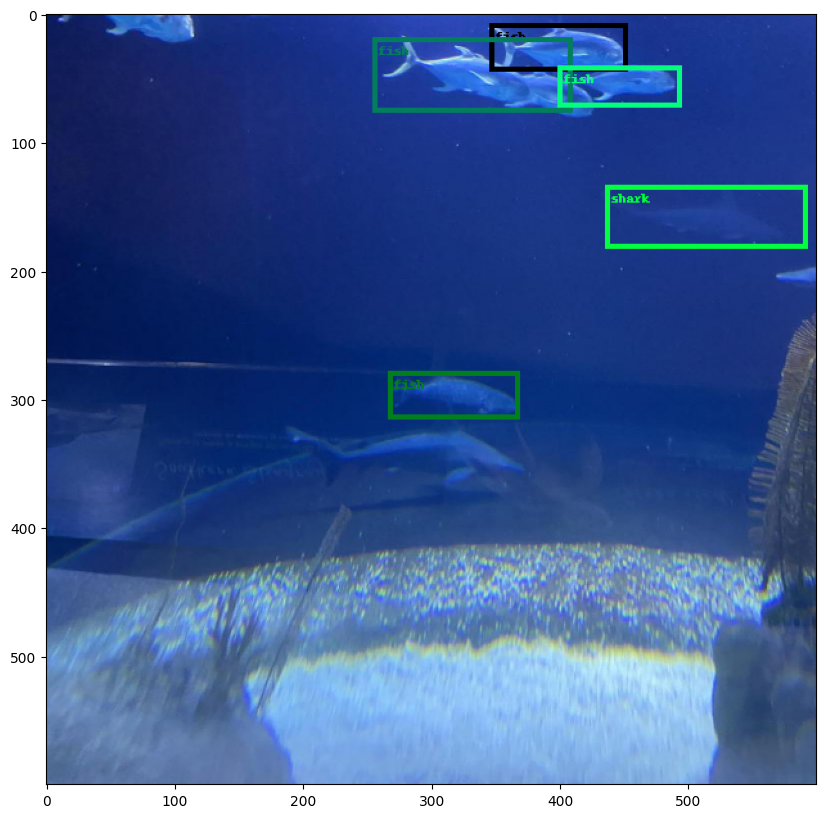

In [26]:
fig = plt.figure(figsize=(14, 10))#tạo một đối tượng hình (figure) với kích thước 14x10 inch để vẽ hình ảnh và các hộp giới hạn lên đó.
#hiển thị hình ảnh và các hộp giới hạn. Các đối số trong imshow
#Một hàm để vẽ các hộp giới hạn lên hình ảnh.
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))
# tạo một hình ảnh trực quan bằng cách vẽ các hộp giới hạn (bounding boxes) trên hình ảnh img_int dựa trên kết quả dự đoán từ biến pred.